In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from PIL import Image
import skimage
from skimage import measure
%matplotlib inline

Using TensorFlow backend.


In [2]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\"

#model = load_model(path + 'models/' + 'EDGEnet_run_epoch_4.h5')

model = load_model(path + 'LER_machine_learning\\models\\' + 'Linenet_image3_round_L1_epoch_2.h5')

In [3]:
sigma = 1.4
alpha = 0.7
Xi = 40
width = 20
space = 40
noise = 2
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

original_file = path + 'original_images3\\oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images3\\nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
linescan_file = path + 'linescans\\linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
im = np.array(Image.open(original_file))
im = im/256
imnoisy = np.array(Image.open(noisy_file))
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,256,1)

predict = np.zeros([1,1024,256,2])
for k in range(4):
    predict[:,k*256:(k+1)*256, 0:256, :] = model.predict(imnoisy[:,k*256:(k+1)*256, 0:256, :])
    #print(model.predict(imnoisy[:,k*256:(k+1)*256, 0:256, :]).shape)

predict = predict.reshape(1024,256,2)
imnoisy = imnoisy.reshape(1024,256)

8192
PSNR noisy image =  10.2231774411
PSNR predicted image =  24.8763569261


Text(0.5,1,'Predicted Denoised Image \n PSNR = 24.876356926127876')

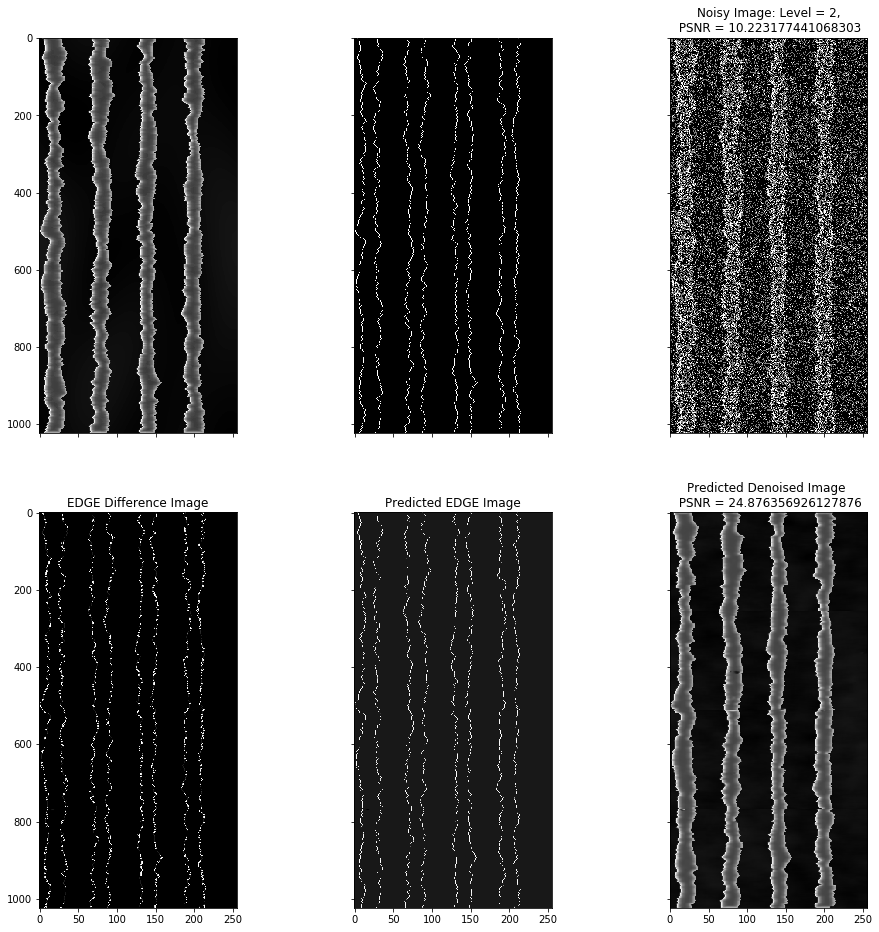

In [4]:
linescan = []
with open(linescan_file,'r') as f:
    for i,line in enumerate(f):
        if i < 8192:
            a, b = line.split(',')
            linescan.append(float(b))
        else:
            break
print(len(linescan))

linescan = np.array(linescan)
linescan = linescan + shift
linescan = linescan.round().astype(int)
edgeimage = np.zeros((1024,256))

for k in range(8):                                  #for k edges
    if k%2 == 0:                                    #keep even edges same 
        edge = linescan[k*1024:(k+1)*1024]
    else:
        edge = np.flip(linescan[k*1024:(k+1)*1024],0)  #flip odd edges

    for i in range(1024):
        if edge[i] >= 0 and edge[i] <= 255:
            edgeimage[i, edge[i]] = 1
            edgeimage[i, edge[i]] = 1

            
psnr_noisy = measure.compare_psnr(im,imnoisy.astype(float))
psnr_predict = measure.compare_psnr(im,predict[:,:,0].astype(float))
print('PSNR noisy image = ', psnr_noisy)
print('PSNR predicted image = ', psnr_predict)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 16), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

ax[0,0].imshow(im,cmap = 'gray',aspect= 0.5)
ax[0,2].set_title('Original Image')

ax[0,1].imshow(edgeimage, cmap = 'gray',aspect= 0.5)
ax[0,2].set_title('True EDGE Image')

ax[0,2].imshow(imnoisy, cmap = 'gray',aspect= 0.5)
ax[0,2].set_title('Noisy Image: Level = {},\n PSNR = {}'.format(noise, psnr_noisy))

ax[1,0].imshow(np.abs(predict[:,:,1] - edgeimage), cmap = 'gray',aspect= 0.5)
ax[1,0].set_title('EDGE Difference Image')

ax[1,1].imshow(predict[:,:,1], cmap = 'gray',aspect= 0.5)
ax[1,1].set_title('Predicted EDGE Image')


ax[1,2].imshow(predict[:,:,0], cmap = 'gray',aspect= 0.5)
ax[1,2].set_title('Predicted Denoised Image \n PSNR = {}'.format(psnr_predict))